In [1]:
from hydra import initialize, compose
from hydra.utils import instantiate

import numpy as np
import torch
import matplotlib.pyplot as plt

import pytorch_lightning as pl
from pytorch_lightning.utilities import move_data_to_device

from bliss.global_env import GlobalEnv

device = torch.device("cuda:7" if torch.cuda.is_available() else "cpu")

Configure encoder to make predictions using weights from a previous training run:

In [2]:
ckpt = "/data/scratch/shreyasc/encoder_111.ckpt"

with initialize(config_path="../../../", version_base=None):
    cfg = compose("lensing_config_dc2", {
        "train.pretrained_weights=" + ckpt,
        })

seed = pl.seed_everything(cfg.train.seed)
GlobalEnv.seed_in_this_program = seed

Seed set to 123123


Load in the test images:

In [3]:
data_source = instantiate(cfg.train.data_source)
data_source.setup("test")
test_dl = data_source.test_dataloader()

In [4]:
test_data = []
for batch in test_dl:
    test_data.append(move_data_to_device(batch, device))

Load in encoder weights:

In [5]:
encoder = instantiate(cfg.encoder).to(device)
encoder_state_dict = torch.load(cfg.train.pretrained_weights, map_location=device)["state_dict"]
encoder.load_state_dict(encoder_state_dict)
encoder = encoder.eval()

In [6]:
confidence_levels = torch.linspace(0.05, 0.95, steps = 19)

ci_quantiles = torch.distributions.Normal(0, 1).icdf(1 - (1 - confidence_levels)/2).to(device)

In [7]:
shear1_true = torch.zeros(len(test_data), 64, device='cpu')
shear2_true = torch.zeros(len(test_data), 64, device='cpu')
convergence_true = torch.zeros(len(test_data), 64, device='cpu')

shear1_ci_lower = torch.zeros(len(test_data), 64, len(ci_quantiles), device='cpu')
shear1_ci_upper = torch.zeros(len(test_data), 64, len(ci_quantiles), device='cpu')
shear2_ci_lower = torch.zeros(len(test_data), 64, len(ci_quantiles), device='cpu')
shear2_ci_upper = torch.zeros(len(test_data), 64, len(ci_quantiles), device='cpu')
convergence_ci_lower = torch.zeros(len(test_data), 64, len(ci_quantiles), device='cpu')
convergence_ci_upper = torch.zeros(len(test_data), 64, len(ci_quantiles), device='cpu')

for i in range(len(test_data)):
    print(f'test image {i}')
    
    with torch.no_grad():
        shear1_true[i] = test_data[i]['tile_catalog']['shear_1'].squeeze().flatten()
        shear2_true[i] = test_data[i]['tile_catalog']['shear_2'].squeeze().flatten()
        convergence_true[i] = test_data[i]['tile_catalog']['convergence'].squeeze().flatten()
        
        input_lst = [inorm.get_input_tensor(test_data[i]) for inorm in encoder.image_normalizers]
        inputs = torch.cat(input_lst, dim=2)

        x_features = encoder.features_net(inputs)
        x_cat_marginal = encoder.catalog_net(x_features).squeeze().flatten(0,1).unsqueeze(-1)
        
        shear1_ci_lower[i] = x_cat_marginal[:,0,:] - ci_quantiles * x_cat_marginal[:,1,:].exp().sqrt()
        shear1_ci_upper[i] = x_cat_marginal[:,0,:] + ci_quantiles * x_cat_marginal[:,1,:].exp().sqrt()
        shear2_ci_lower[i] = x_cat_marginal[:,2,:] - ci_quantiles * x_cat_marginal[:,3,:].exp().sqrt()
        shear2_ci_upper[i] = x_cat_marginal[:,2,:] + ci_quantiles * x_cat_marginal[:,3,:].exp().sqrt()
        convergence_ci_lower[i] = x_cat_marginal[:,4,:] - ci_quantiles * x_cat_marginal[:,5,:].exp().sqrt()
        convergence_ci_upper[i] = x_cat_marginal[:,4,:] + ci_quantiles * x_cat_marginal[:,5,:].exp().sqrt()

test image 0
test image 1
test image 2
test image 3
test image 4
test image 5
test image 6
test image 7
test image 8
test image 9
test image 10
test image 11
test image 12
test image 13
test image 14
test image 15
test image 16
test image 17
test image 18
test image 19
test image 20
test image 21
test image 22
test image 23
test image 24
test image 25
test image 26
test image 27
test image 28
test image 29
test image 30
test image 31
test image 32
test image 33
test image 34
test image 35
test image 36
test image 37
test image 38
test image 39


In [8]:
shear1_coverage_probs = ((shear1_ci_lower.flatten(0,1) <= shear1_true.flatten(0,1).unsqueeze(-1)) * (shear1_true.flatten(0,1).unsqueeze(-1) <= shear1_ci_upper.flatten(0,1))).float().mean(0)
shear2_coverage_probs = ((shear2_ci_lower.flatten(0,1) <= shear2_true.flatten(0,1).unsqueeze(-1)) * (shear2_true.flatten(0,1).unsqueeze(-1) <= shear2_ci_upper.flatten(0,1))).float().mean(0)
convergence_coverage_probs = ((convergence_ci_lower.flatten(0,1) <= convergence_true.flatten(0,1).unsqueeze(-1)) * (convergence_true.flatten(0,1).unsqueeze(-1) <= convergence_ci_upper.flatten(0,1))).float().mean(0)

In [9]:
for i, ci in enumerate(confidence_levels):
    print(f'Confidence level: {ci:.2f}, Shear 1: {shear1_coverage_probs[i]:.4f}, Shear 2: {shear2_coverage_probs[i]:.4f}, Convergence: {convergence_coverage_probs[i]:.4f}')

Confidence level: 0.05, Shear 1: 0.0437, Shear 2: 0.0488, Convergence: 0.0488
Confidence level: 0.10, Shear 1: 0.0902, Shear 2: 0.1031, Convergence: 0.1000
Confidence level: 0.15, Shear 1: 0.1367, Shear 2: 0.1570, Convergence: 0.1473
Confidence level: 0.20, Shear 1: 0.1813, Shear 2: 0.2121, Convergence: 0.1949
Confidence level: 0.25, Shear 1: 0.2270, Shear 2: 0.2652, Convergence: 0.2465
Confidence level: 0.30, Shear 1: 0.2820, Shear 2: 0.3145, Convergence: 0.2977
Confidence level: 0.35, Shear 1: 0.3320, Shear 2: 0.3590, Convergence: 0.3516
Confidence level: 0.40, Shear 1: 0.3820, Shear 2: 0.4078, Convergence: 0.4043
Confidence level: 0.45, Shear 1: 0.4258, Shear 2: 0.4578, Convergence: 0.4516
Confidence level: 0.50, Shear 1: 0.4781, Shear 2: 0.5031, Convergence: 0.4988
Confidence level: 0.55, Shear 1: 0.5309, Shear 2: 0.5555, Convergence: 0.5461
Confidence level: 0.60, Shear 1: 0.5789, Shear 2: 0.6074, Convergence: 0.5895
Confidence level: 0.65, Shear 1: 0.6297, Shear 2: 0.6508, Conver

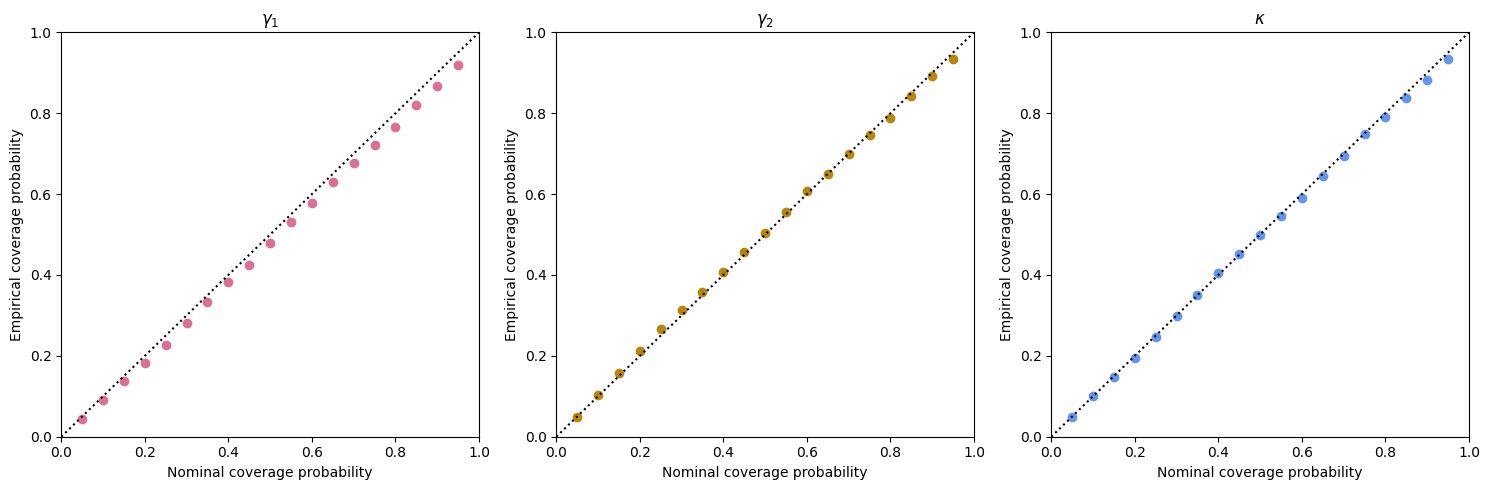

In [10]:
fig, ax = plt.subplots(1, 3, figsize=(15, 5))

_ = ax[0].axline((0,0), slope = 1, linestyle = 'dotted', color = 'black')
_ = ax[0].scatter(confidence_levels, shear1_coverage_probs, color='palevioletred')
_ = ax[0].set_title('$\gamma_1$')
_ = ax[0].set_xlabel('Nominal coverage probability')
_ = ax[0].set_ylabel('Empirical coverage probability')
_ = ax[0].set_xlim(0, 1)
_ = ax[0].set_ylim(0, 1)

_ = ax[1].axline((0,0), slope = 1, linestyle = 'dotted', color = 'black')
_ = ax[1].scatter(confidence_levels, shear2_coverage_probs, color='darkgoldenrod')
_ = ax[1].set_title('$\gamma_2$')
_ = ax[1].set_xlabel('Nominal coverage probability')
_ = ax[1].set_ylabel('Empirical coverage probability')
_ = ax[1].set_xlim(0, 1)
_ = ax[1].set_ylim(0, 1)

_ = ax[2].axline((0,0), slope = 1, linestyle = 'dotted', color = 'black')
_ = ax[2].scatter(confidence_levels, convergence_coverage_probs, color='cornflowerblue')
_ = ax[2].set_title('$\kappa$')
_ = ax[2].set_xlabel('Nominal coverage probability')
_ = ax[2].set_ylabel('Empirical coverage probability')
_ = ax[2].set_xlim(0, 1)
_ = ax[2].set_ylim(0, 1)

fig.tight_layout()

fig.savefig("figures/figure6.png", dpi = 300, transparent = True, bbox_inches = 'tight', pad_inches = 0)

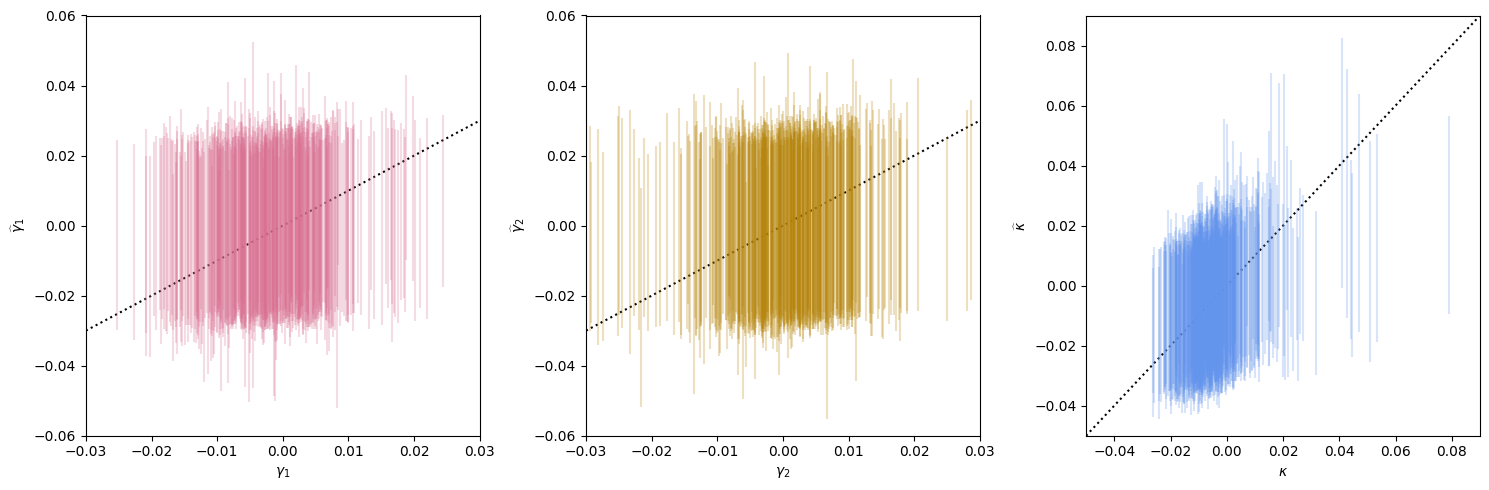

In [11]:
fig, ax = plt.subplots(1, 3, figsize=(15, 5))

np.random.seed(0)
indexes = np.random.choice(len(test_data) * 64, 500, replace=False)

_ = ax[0].axline((0,0), slope = 1, linestyle = 'dotted', color = 'black')
_ = ax[0].errorbar(x = shear1_true.flatten(0,1)[indexes],
                    y = 0.5 * (shear1_ci_lower.flatten(0,1)[...,-1] + shear1_ci_upper.flatten(0,1)[...,-1])[indexes],
                    yerr = (shear1_ci_upper.flatten(0,1)[...,-1] - shear1_ci_lower.flatten(0,1)[...,-1])[indexes],
                    fmt = 'none', alpha = 0.25, color='palevioletred')
_ = ax[0].set_xlabel('$\gamma_1$')
_ = ax[0].set_ylabel(r'$\widehat{\gamma}_1$')
_ = ax[0].set_xlim(-0.03, 0.03)
_ = ax[0].set_ylim(-0.06, 0.06)

_ = ax[1].axline((0,0), slope = 1, linestyle = 'dotted', color = 'black')
_ = ax[1].errorbar(x = shear2_true.flatten(0,1)[indexes],
                    y = 0.5 * (shear2_ci_lower.flatten(0,1)[...,-1] + shear2_ci_upper.flatten(0,1)[...,-1])[indexes],
                    yerr = (shear2_ci_upper.flatten(0,1)[...,-1] - shear2_ci_lower.flatten(0,1)[...,-1])[indexes],
                    fmt = 'none', alpha = 0.25, color='darkgoldenrod')
_ = ax[1].set_xlabel('$\gamma_2$')
_ = ax[1].set_ylabel(r'$\widehat{\gamma}_2$')
_ = ax[1].set_xlim(-0.03, 0.03)
_ = ax[1].set_ylim(-0.06, 0.06)

_ = ax[2].axline((0,0), slope = 1, linestyle = 'dotted', color = 'black')
_ = ax[2].errorbar(x = convergence_true.flatten(0,1)[indexes],
                    y = 0.5 * (convergence_ci_lower.flatten(0,1)[...,-1] + convergence_ci_upper.flatten(0,1)[...,-1])[indexes],
                    yerr = (convergence_ci_upper.flatten(0,1)[...,-1] - convergence_ci_lower.flatten(0,1)[...,-1])[indexes],
                    fmt = 'none', alpha = 0.25, color='cornflowerblue')
_ = ax[2].set_xlabel('$\kappa$')
_ = ax[2].set_ylabel(r'$\widehat{\kappa}$')
_ = ax[2].set_xlim(-0.05, 0.09)
_ = ax[2].set_ylim(-0.05, 0.09)

_ = fig.tight_layout()

fig.savefig("figures/figure7.png", dpi = 300, transparent = True, bbox_inches = 'tight', pad_inches = 0)